This file will take the deltaX, deltaY (with these two possibly combined into deltaR), deltaE, and KS p-value and use them to form a model

In [3]:
from evwTools import *

In [4]:
# Load libraries
import sklearn
import pandas
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from pandas.plotting import andrews_curves
from pandas.plotting import parallel_coordinates
from pandas.plotting import radviz
import seaborn as sns
import numpy as np

Get all of the good and the bad files

In [5]:
#goodfiles = ['TestEvents_deltaT_lt_2_deltaR_lt_point25_deltaE_lt_500_timeCut_1000_Oct29.root']
goodfiles = ['TestEvents_KS_gt_point95_timeCut_1000_Oct29.root']
badfiles = ['TestEvents_KS_lt_point5_timeCut_1000_Oct29.root', 
            'TestEvents_rX_3point5_rY_2point5_timeCut_100_Oct29.root', 
            'TestEvents_deltaE_gt_2000_100_Oct29.root',
            'TestEvents_deltaT_gt_3_timeCut_100_Oct29.root']
path = "/home/jlab/g-2/eastVsWest/data/dataExternal/"

Loop over the files, add their dataframes together into one big one

In [6]:
for i, file in enumerate(badfiles):
    print("Starting:",file)
    f = uproot.open(path+file)
    t = f['evwTree']
    
    if(i == 0):
        dfbad = t.pandas.df(['deltaX','deltaY','deltaE', 'energyWest', 'deltaT', 'timeCorr'])
        dfbad['class'] = pandas.Series(0, index=dfbad.index)
    else:
        dfi = t.pandas.df(['deltaX','deltaY','deltaE', 'energyWest', 'deltaT', 'timeCorr'])
        dfi['class'] = pandas.Series(0, index=dfi.index)
        dfbad = pandas.concat([dfbad,dfi])
        
print("All done")

Starting: TestEvents_KS_lt_point5_timeCut_1000_Oct29.root
Starting: TestEvents_rX_3point5_rY_2point5_timeCut_100_Oct29.root
Starting: TestEvents_deltaE_gt_2000_100_Oct29.root
Starting: TestEvents_deltaT_gt_3_timeCut_100_Oct29.root
All done


In [7]:
dfbad.describe()

,deltaX,deltaY,deltaE,energyWest,deltaT,timeCorr,class
count,238095.000000,238095.000000,238095.000000,238095.000000,238095.000000,238095.000000,238095.0
mean,0.251599,-0.001806,-33.738672,528.956398,-0.964446,-0.741791,0.0
std,2.130061,0.802635,197.021319,528.464135,1.524945,0.852446,0.0
min,-8.850602,-6.221207,-2960.346607,4.607287,-17.051629,-2.533535,0.0
25%,-0.726474,-0.216461,-91.130580,164.955499,-0.992071,-0.955265,0.0
50%,-0.031641,-0.004312,-50.315340,263.837714,-0.614126,-0.539326,0.0
75%,1.448320,0.213791,-10.881496,775.225138,-0.141529,-0.100543,0.0
max,9.275191,5.775490,2072.166565,14087.190082,14.983712,0.543326,0.0


In [8]:
for i, file in enumerate(goodfiles):
    print("Starting:",file)
    f = uproot.open(path+file)
    t = f['evwTree']
    
    if(i == 0):
        dfgood = t.pandas.df(['deltaX','deltaY','deltaE', 'energyWest', 'deltaT', 'timeCorr'])
        dfgood['class'] = pandas.Series(1, index=dfgood.index)
    else:
        dfi = t.pandas.df(['deltaX','deltaY','deltaE', 'energyWest', 'deltaT', 'timeCorr'])
        dfi['class'] = pandas.Series(1, index=dfi.index)
        dfgood = pandas.concat([dfgood,dfi])
        
print("All done")

Starting: TestEvents_KS_gt_point95_timeCut_1000_Oct29.root
All done


In [9]:
dfgood.describe()

,deltaX,deltaY,deltaE,energyWest,deltaT,timeCorr,class
count,3.429085e+06,3.429085e+06,3.429085e+06,3.429085e+06,3.429085e+06,3.429085e+06,3429085.0
mean,-9.134321e-03,-2.993461e-03,-3.463479e+01,1.019470e+03,-7.247115e-01,-7.232070e-01,1.0
std,1.990947e-01,9.901956e-02,1.732791e+02,5.530079e+02,8.357021e-01,8.348514e-01,0.0
min,-4.524257e+00,-2.656853e+00,-1.421918e+03,1.084019e+01,-6.321893e+00,-2.533535e+00,1.0
25%,-6.411738e-02,-4.326967e-02,-1.108362e+02,5.577836e+02,-9.466264e-01,-9.552652e-01,1.0
50%,-1.283321e-02,0.000000e+00,-2.067816e+01,1.018199e+03,-5.386544e-01,-5.393264e-01,1.0
75%,3.496452e-02,3.879669e-02,3.608734e+01,1.454661e+03,-1.438687e-01,-1.844449e-01,1.0
max,4.892908e+00,2.431577e+00,1.944235e+03,4.266322e+03,1.511725e+00,5.433260e-01,1.0


In [10]:
dfmachinelearning = pandas.concat([dfbad,dfgood])
dfmachinelearning['deltaTcorr']  = dfmachinelearning['deltaT'] - dfmachinelearning['timeCorr']

In [11]:
dfmachinelearning.describe()

,deltaX,deltaY,deltaE,energyWest,deltaT,timeCorr,class,deltaTcorr
count,3.667180e+06,3.667180e+06,3.667180e+06,3.667180e+06,3.667180e+06,3.667180e+06,3.667180e+06,3.667180e+06
mean,7.794017e-03,-2.916375e-03,-3.457661e+01,9.876232e+02,-7.402765e-01,-7.244135e-01,9.350741e-01,-1.586292e-02
std,5.794569e-01,2.258206e-01,1.749185e+02,5.645365e+02,8.986239e-01,8.360174e-01,2.463951e-01,3.363232e-01
min,-8.850602e+00,-6.221207e+00,-2.960347e+03,4.607287e+00,-1.705163e+01,-2.533535e+00,0.000000e+00,-1.495386e+01
25%,-6.792774e-02,-4.562209e-02,-1.084907e+02,4.999976e+02,-9.485830e-01,-9.552652e-01,1.000000e+00,-3.405938e-02
50%,-1.318486e-02,0.000000e+00,-2.387470e+01,9.814077e+02,-5.415439e-01,-5.393264e-01,1.000000e+00,-1.103166e-03
75%,3.804532e-02,4.058278e-02,3.383321e+01,1.435034e+03,-1.437354e-01,-1.844449e-01,1.000000e+00,3.242618e-02
max,9.275191e+00,5.775490e+00,2.072167e+03,1.408719e+04,1.498371e+01,5.433260e-01,1.000000e+00,1.484931e+01


Now that we have the dataset assembled, lets jump into the machine learning

In [12]:
dataset = dfmachinelearning[['deltaX','deltaY','deltaE','deltaTcorr','energyWest','class']]
nCols = 6 #update when you change the number of oclumns in the dataset

print(type(dataset))

<class 'pandas.core.frame.DataFrame'>


In [13]:
# shape
print((dataset.shape)[0])

3667180


In [14]:
# head
dataset.head()

,deltaX,deltaY,deltaE,deltaTcorr,energyWest,class
0,-1.296642,-0.214265,-21.500595,0.015660,241.222784,0
1,1.352749,0.200592,-53.085383,0.013529,188.053066,0
2,-4.607376,0.696312,166.128193,-0.012300,56.610818,0
3,-0.050374,0.078892,-204.705447,-0.030089,1216.764477,0
4,0.032458,0.006391,30.746344,0.023744,1274.134430,0


In [15]:
dataset.describe()

,deltaX,deltaY,deltaE,deltaTcorr,energyWest,class
count,3.667180e+06,3.667180e+06,3.667180e+06,3.667180e+06,3.667180e+06,3.667180e+06
mean,7.794017e-03,-2.916375e-03,-3.457661e+01,-1.586292e-02,9.876232e+02,9.350741e-01
std,5.794569e-01,2.258206e-01,1.749185e+02,3.363232e-01,5.645365e+02,2.463951e-01
min,-8.850602e+00,-6.221207e+00,-2.960347e+03,-1.495386e+01,4.607287e+00,0.000000e+00
25%,-6.792774e-02,-4.562209e-02,-1.084907e+02,-3.405938e-02,4.999976e+02,1.000000e+00
50%,-1.318486e-02,0.000000e+00,-2.387470e+01,-1.103166e-03,9.814077e+02,1.000000e+00
75%,3.804532e-02,4.058278e-02,3.383321e+01,3.242618e-02,1.435034e+03,1.000000e+00
max,9.275191e+00,5.775490e+00,2.072167e+03,1.484931e+01,1.408719e+04,1.000000e+00


In [16]:
dfsample = dataset.sample(10000,random_state=12345)

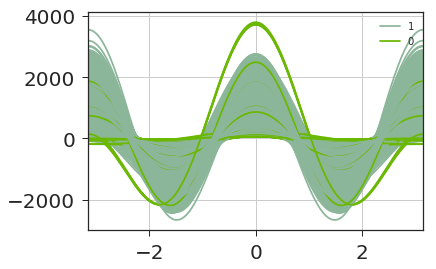

In [17]:
# descriptions and visualizations
andrews_curves(dfsample, 'class')
plt.show()

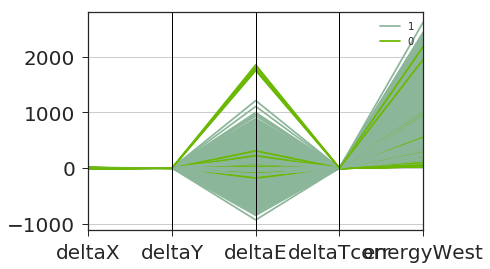

In [18]:
parallel_coordinates(dfsample, 'class')
plt.show()

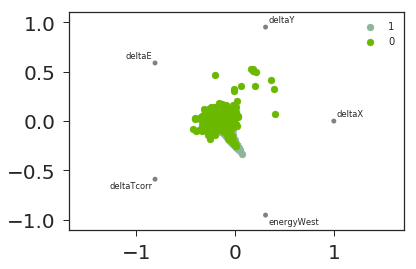

In [19]:
radviz(dfsample, 'class')
plt.show()

In [20]:
# class distribution
print("Full:")
print(dataset.groupby('class').size())
print(" ")
print("Sample:")
print(dfsample.groupby('class').size())

Full:
class
0     238095
1    3429085
dtype: int64
 
Sample:
class
0     628
1    9372
dtype: int64


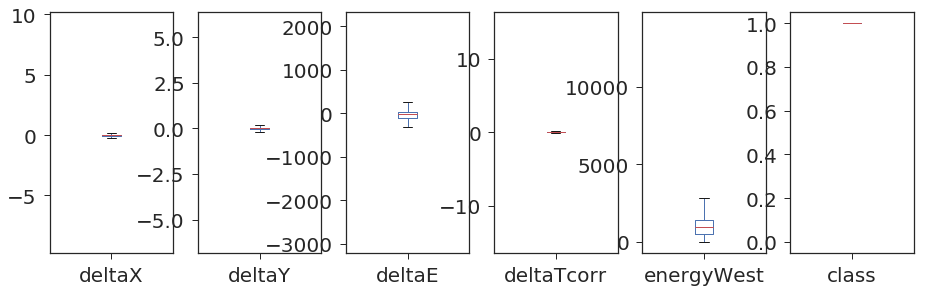

In [21]:
# box and whisker plots
#fix, ax = plt.subplots(figsize=(25,4))
dataset.plot(kind='box', subplots=True, layout=(19,19), figsize=(50,100), sharex=False, sharey=False)
dataset.boxplot()
plt.show()

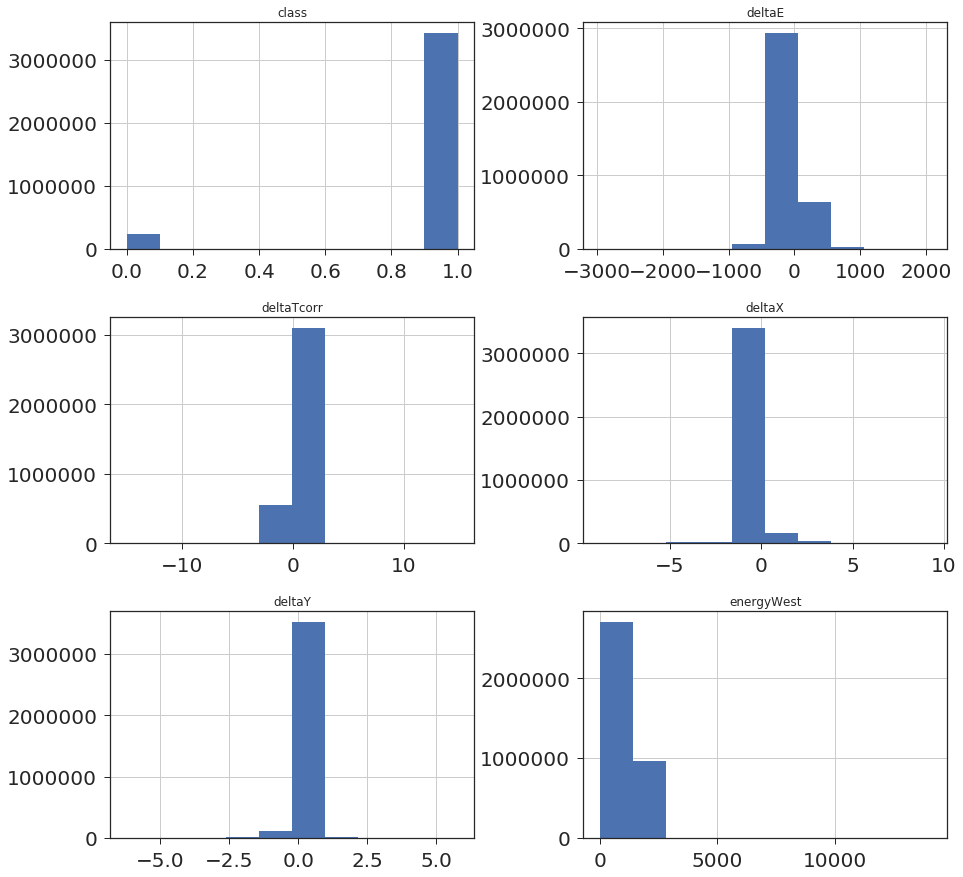

In [22]:
# histograms
dataset.hist(figsize=(15,15))
plt.show()

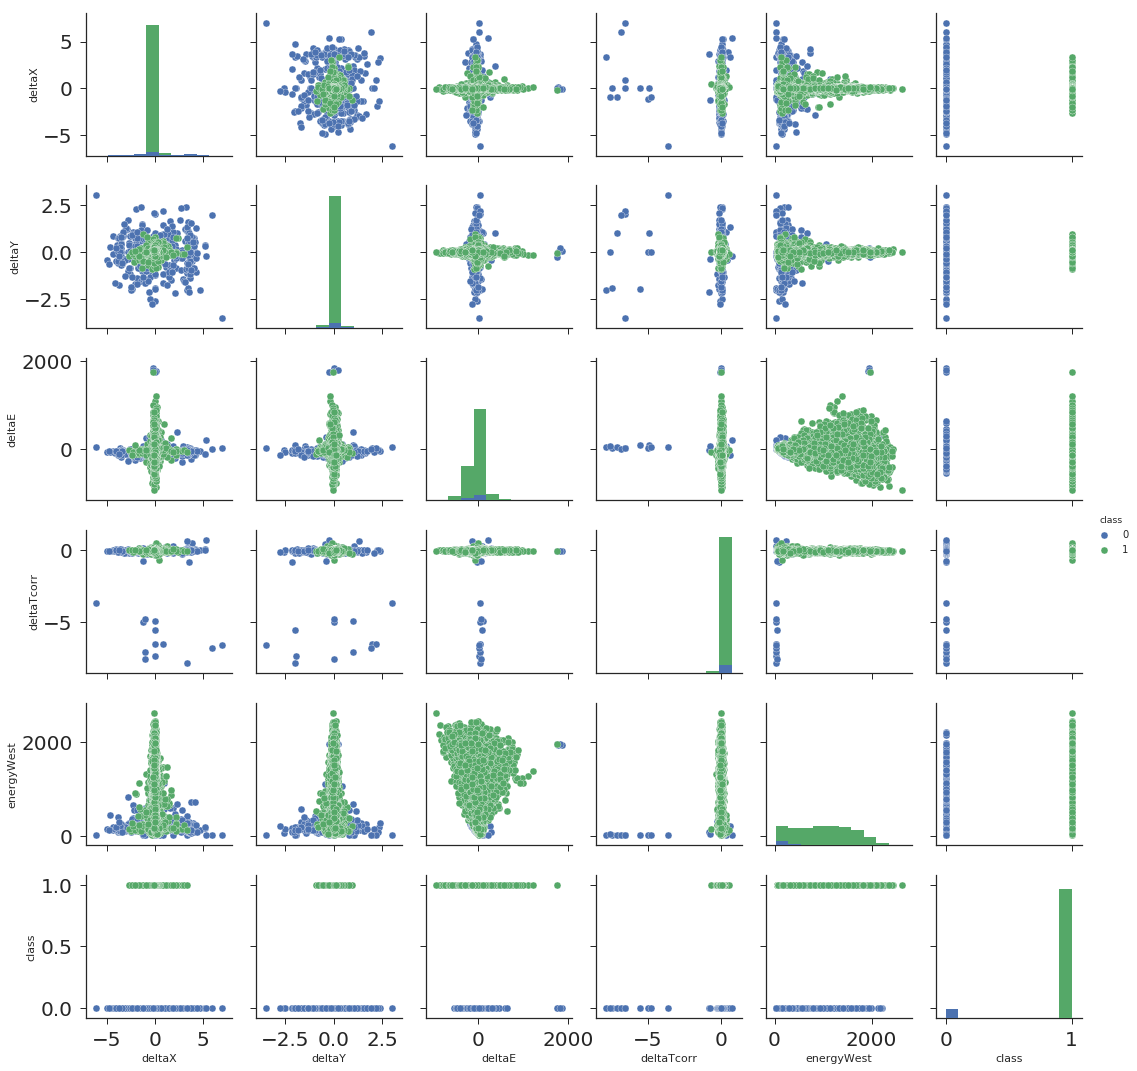

In [23]:
# scatter plot matrix
sns.pairplot(dfsample, hue="class")
#plt.savefig("./ding.pdf")
#plt.savefig("./ding.png")
plt.show()

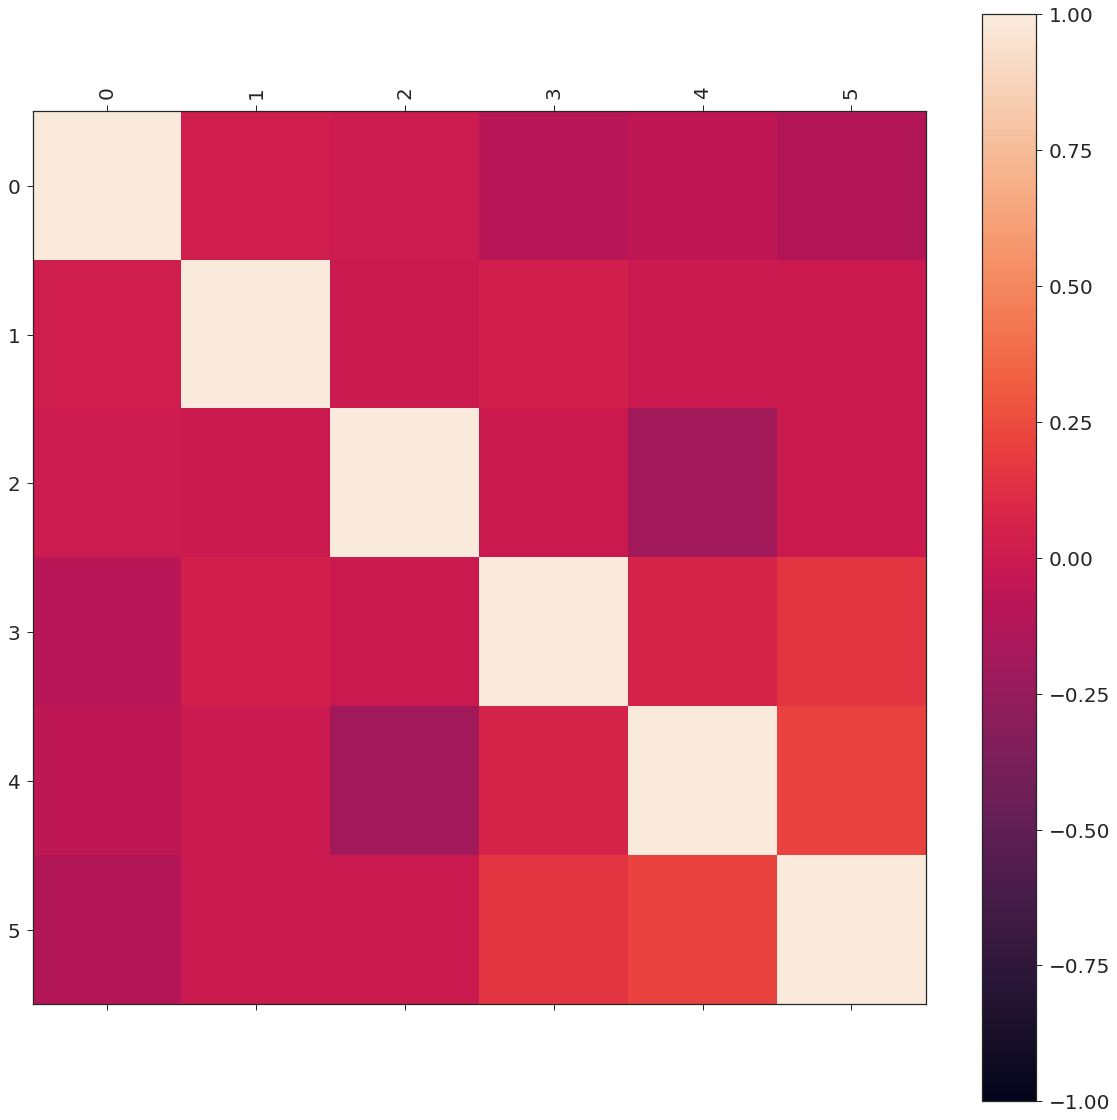

In [24]:
#correllation plot
correlations = dataset.corr()
# plot correlation matrix
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
#ticks = np.arange(0,20,1)
#ax.set_xticks(ticks)
#ax.set_yticks(ticks)
#ax.set_xticklabels(names)
#ax.set_yticklabels(names)
plt.xticks(rotation=90)
plt.show()

In [25]:
# Split-out validation dataset
array = dataset.values

X = array[:,0:nCols-1]
Y = array[:,nCols-1]
print(Y)
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

ding = np.column_stack((X_train,Y_train))
print(ding)
dong = np.column_stack((X_validation,Y_validation))

#np.savetxt("./data/JetSummary_1000_training.csv", ding, delimiter=", ")
#np.savetxt("./data/JetSummary_1000_validation.csv", dong, fmt='%i, %i, %i, %i, %i, %i, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %s')
#np.savetxt("./data/JetSummary_1000_training.csv", ding, fmt='%i, %i, %i, %i, %i, %i, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %f, %s')

[0. 0. 0. ... 1. 1. 1.]
[[ 1.71050120e-04  5.96845624e-02 -3.81128764e+01 -3.49570119e-02
   1.43449453e+03  1.00000000e+00]
 [-1.45910831e-02  9.03246099e-04 -2.07947557e+01 -6.65757989e-02
   2.39233956e+02  1.00000000e+00]
 [ 1.09550252e-01  2.44825006e-02  1.08030099e+02  2.48352474e-02
   1.64900555e+03  1.00000000e+00]
 ...
 [ 1.24714521e-01 -5.61368793e-02  9.46532043e-01 -6.50522041e-02
   1.22876364e+02  1.00000000e+00]
 [ 1.77736632e-01  0.00000000e+00  4.79862915e+02 -9.78610984e-02
   8.18227172e+02  1.00000000e+00]
 [-7.95547003e-02 -1.58406190e-01 -5.73356773e+01  1.34708664e-02
   5.74172321e+02  1.00000000e+00]]


In [26]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

Starting: LR
LR: 0.937341 (0.000315)
Starting: QDA
QDA: 0.957013 (0.000257)
Starting: Neural
Neural: 0.966428 (0.000685)
Starting: ADA
ADA: 0.965059 (0.000186)
Starting: DTC
DTC: 0.948407 (0.000347)


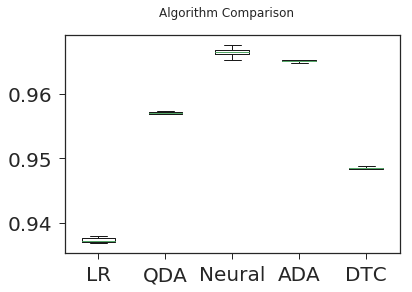

In [27]:

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('GNB', GaussianNB()))
#models.append(('SVM', SVC()))
#models.append(('SVMlin', SVC(kernel="linear", C=0.025)))
#models.append(('SVMpoly', SVC(kernel="poly")))
#models.append(('SVMg2', SVC(gamma=2, C=1)))
models.append(('Neural', MLPClassifier()))
#models.append(('RFC', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)))
#models.append(('ADA3', AdaBoostClassifier(base_estimator=None, n_estimators=100, learning_rate=0.5, algorithm='SAMME.R', random_state=None)))
#models.append(('EXT', ExtraTreesClassifier()))
#models.append(('RC', RidgeClassifier()))
#models.append(('RNeigh', RadiusNeighborsClassifier(200)))
#models.append(('ccCV', CalibratedClassifierCV()))
models.append(('DTC', DecisionTreeClassifier()))
#models.append(('ETC', ExtraTreeClassifier()))


# evaluate each model in turn
results = []
names = []
for name, model in models:
    print("Starting:", name)
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [31]:
#export the models for later use - https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
import pickle
for name, model in models:
    filename = './models/'+name+'_finalized_model.sav'
    pickle.dump(model, open(filename, 'wb'))
    print("Saved model:", name)

Saved model: LR
Saved model: QDA
Saved model: Neural
Saved model: ADA
Saved model: DTC


In [1]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylim(0.9,1)
plt.show()

NameError: name 'plt' is not defined

In [29]:
# Make predictions on validation dataset
#ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={' tau':1, ' DIS':0.001}), n_estimators=100, learning_rate=0.5, algorithm='SAMME.R', random_state=None)
ada = AdaBoostClassifier(base_estimator=None, n_estimators=100, learning_rate=0.5, algorithm='SAMME.R', random_state=None)
#ada = ExtraTreesClassifier(class_weight={' tau':1000, ' DIS':1})
#ada = LogisticRegression(class_weight={' tau':10, ' DIS':1})
ada.fit(X_train, Y_train)
predictions = ada.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9650889784521076
[[ 26534  21220]
 [  4385 681297]]
             precision    recall  f1-score   support

        0.0       0.86      0.56      0.67     47754
        1.0       0.97      0.99      0.98    685682

avg / total       0.96      0.97      0.96    733436

